In [1]:
!pip install timm

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter
import timm

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Set Seeds for Reproducibility

In [3]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [4]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False, 
                 imaging_type_encoder=None, fit_imaging_type_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths), tissue type (labels), and imaging type columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
            imaging_type_encoder (LabelEncoder, optional): Pre-fitted imaging type encoder.
            fit_imaging_type_encoder (bool): Whether to fit the imaging type encoder.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        # Handle tissue type labels
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        # Handle imaging type encoding
        if imaging_type_encoder is None:
            self.imaging_type_encoder = LabelEncoder()
            if fit_imaging_type_encoder:
                self.imaging_types = self.imaging_type_encoder.fit_transform(self.data['imaging type'])
            else:
                raise ValueError("Must provide imaging_type_encoder or set fit_imaging_type_encoder=True")
        else:
            self.imaging_type_encoder = imaging_type_encoder
            self.imaging_types = self.imaging_type_encoder.transform(self.data['imaging type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        imaging_type = self.imaging_types[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long), torch.tensor(imaging_type, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_imaging_type_encoder(self):
        """Return the imaging type encoder for use with other datasets"""
        return self.imaging_type_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [6]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding and imaging type encoding
    """
    # Create training dataset and fit both label encoders
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True,
        fit_imaging_type_encoder=True
    )
    
    # Get the fitted label encoders
    le = train_dataset.get_label_encoder()
    imaging_type_encoder = train_dataset.get_imaging_type_encoder()
    
    # Create validation dataset using the same encoders
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    # Create test dataset using the same encoders
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    return train_dataset, val_dataset, test_dataset, le, imaging_type_encoder

# Dataloader

In [7]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [8]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder, imaging_type_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels, _ in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels, imaging_types in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    imaging_types = imaging_types.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs, imaging_types)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels, imaging_types in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                imaging_types = imaging_types.to(self.device)
                
                outputs = self.model(inputs, imaging_types)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [12]:
class EfficientFormerWithImagingType(nn.Module):
    """EfficientFormer with imaging type as additional input"""
    
    def __init__(self, model_type='l1', num_classes=4, num_imaging_types=2, pretrained=True, embedding_dim=16):
        super(EfficientFormerWithImagingType, self).__init__()
        
        # Load pretrained EfficientFormer using timm
        self.efficientformer = timm.create_model(f'efficientformer_{model_type}', pretrained=pretrained, num_classes=0)
        
        # Get the number of features from the model
        num_features = self.efficientformer.num_features
        
        # Embedding layer for imaging type
        self.imaging_type_embedding = nn.Embedding(num_imaging_types, embedding_dim)
        
        # New classifier that combines CNN features and imaging type embedding
        self.classifier = nn.Sequential(
            nn.Linear(num_features + embedding_dim, 512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, images, imaging_types):
        # Extract features from EfficientFormer
        features = self.efficientformer(images)
        
        # Get imaging type embeddings
        imaging_embedding = self.imaging_type_embedding(imaging_types)
        
        # Concatenate features with imaging type embeddings
        combined_features = torch.cat([features, imaging_embedding], dim=1)
        
        # Final classification
        output = self.classifier(combined_features)
        
        return output


def create_efficientformer_model(model_type='l1', num_classes=4, num_imaging_types=2, pretrained=True, embedding_dim=16):
    """
    Create EfficientFormer model with imaging type for bladder tissue classification
    
    Args:
        model_type (str): Model variant - 'l1', 'l3', or 'l7'
        num_classes (int): Number of output classes
        num_imaging_types (int): Number of imaging types (e.g., WLI, NBI)
        pretrained (bool): Whether to use pretrained weights
        embedding_dim (int): Dimension of imaging type embedding
    
    Returns:
        model: EfficientFormer model with imaging type support
    """
    model = EfficientFormerWithImagingType(
        model_type=model_type,
        num_classes=num_classes,
        num_imaging_types=num_imaging_types,
        pretrained=pretrained,
        embedding_dim=embedding_dim
    )
    return model


# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train EfficientFormer L1

Training EfficientFormer L1 with Imaging Type
Number of imaging types: 2
Imaging types: ['NBI' 'WLI']


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.09it/s, Loss=0.5453, Acc=0.8207]


Train Loss: 0.5453 Acc: 0.8207 Macro-F1: 0.7760


Val : 100%|██████████| 10/10 [00:01<00:00,  6.73it/s, Loss=0.8128, Acc=0.7500]


Val Loss: 0.8128 Acc: 0.7500 Macro-F1: 0.7009
✓ New best model saved with validation macro-F1: 0.7009

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.20it/s, Loss=0.2348, Acc=0.9293]


Train Loss: 0.2348 Acc: 0.9293 Macro-F1: 0.9038


Val : 100%|██████████| 10/10 [00:01<00:00,  9.36it/s, Loss=0.4076, Acc=0.8816]


Val Loss: 0.4076 Acc: 0.8816 Macro-F1: 0.8581
✓ New best model saved with validation macro-F1: 0.8581

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.15it/s, Loss=0.1726, Acc=0.9564]


Train Loss: 0.1726 Acc: 0.9564 Macro-F1: 0.9458


Val : 100%|██████████| 10/10 [00:01<00:00,  9.54it/s, Loss=0.3529, Acc=0.8651]


Val Loss: 0.3529 Acc: 0.8651 Macro-F1: 0.8348

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.15it/s, Loss=0.0971, Acc=0.9671]


Train Loss: 0.0971 Acc: 0.9671 Macro-F1: 0.9526


Val : 100%|██████████| 10/10 [00:01<00:00,  9.60it/s, Loss=0.8923, Acc=0.7763]


Val Loss: 0.8923 Acc: 0.7763 Macro-F1: 0.7503

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.10it/s, Loss=0.1267, Acc=0.9572]


Train Loss: 0.1267 Acc: 0.9572 Macro-F1: 0.9472


Val : 100%|██████████| 10/10 [00:01<00:00,  9.69it/s, Loss=0.1010, Acc=0.9309]


Val Loss: 0.1010 Acc: 0.9309 Macro-F1: 0.9368
✓ New best model saved with validation macro-F1: 0.9368

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.15it/s, Loss=0.0818, Acc=0.9745]


Train Loss: 0.0818 Acc: 0.9745 Macro-F1: 0.9690


Val : 100%|██████████| 10/10 [00:01<00:00,  8.77it/s, Loss=0.0934, Acc=0.9671]


Val Loss: 0.0934 Acc: 0.9671 Macro-F1: 0.9686
✓ New best model saved with validation macro-F1: 0.9686

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.16it/s, Loss=0.1229, Acc=0.9688]


Train Loss: 0.1229 Acc: 0.9688 Macro-F1: 0.9575


Val : 100%|██████████| 10/10 [00:01<00:00,  9.59it/s, Loss=0.7962, Acc=0.7829]


Val Loss: 0.7962 Acc: 0.7829 Macro-F1: 0.7701

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.16it/s, Loss=0.0993, Acc=0.9630]


Train Loss: 0.0993 Acc: 0.9630 Macro-F1: 0.9512


Val : 100%|██████████| 10/10 [00:01<00:00,  9.72it/s, Loss=0.0873, Acc=0.9737]


Val Loss: 0.0873 Acc: 0.9737 Macro-F1: 0.9663

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.17it/s, Loss=0.0200, Acc=0.9951]


Train Loss: 0.0200 Acc: 0.9951 Macro-F1: 0.9936


Val : 100%|██████████| 10/10 [00:01<00:00,  9.53it/s, Loss=0.0470, Acc=0.9836]


Val Loss: 0.0470 Acc: 0.9836 Macro-F1: 0.9740
✓ New best model saved with validation macro-F1: 0.9740

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.11it/s, Loss=0.0069, Acc=0.9992]


Train Loss: 0.0069 Acc: 0.9992 Macro-F1: 0.9993


Val : 100%|██████████| 10/10 [00:01<00:00,  9.76it/s, Loss=0.0442, Acc=0.9803]


Val Loss: 0.0442 Acc: 0.9803 Macro-F1: 0.9715

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.21it/s, Loss=0.0048, Acc=0.9992]


Train Loss: 0.0048 Acc: 0.9992 Macro-F1: 0.9992


Val : 100%|██████████| 10/10 [00:01<00:00,  9.59it/s, Loss=0.0411, Acc=0.9836]


Val Loss: 0.0411 Acc: 0.9836 Macro-F1: 0.9741
✓ New best model saved with validation macro-F1: 0.9741

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.11it/s, Loss=0.0030, Acc=1.0000]


Train Loss: 0.0030 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  9.83it/s, Loss=0.0421, Acc=0.9836]


Val Loss: 0.0421 Acc: 0.9836 Macro-F1: 0.9741

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.18it/s, Loss=0.0029, Acc=0.9992]


Train Loss: 0.0029 Acc: 0.9992 Macro-F1: 0.9994


Val : 100%|██████████| 10/10 [00:01<00:00,  9.55it/s, Loss=0.0406, Acc=0.9868]


Val Loss: 0.0406 Acc: 0.9868 Macro-F1: 0.9767
✓ New best model saved with validation macro-F1: 0.9767

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.16it/s, Loss=0.0024, Acc=1.0000]


Train Loss: 0.0024 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  9.73it/s, Loss=0.0383, Acc=0.9901]


Val Loss: 0.0383 Acc: 0.9901 Macro-F1: 0.9831
✓ New best model saved with validation macro-F1: 0.9831

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.14it/s, Loss=0.0014, Acc=1.0000]


Train Loss: 0.0014 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:00<00:00, 10.05it/s, Loss=0.0393, Acc=0.9901]


Val Loss: 0.0393 Acc: 0.9901 Macro-F1: 0.9839
✓ New best model saved with validation macro-F1: 0.9839

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.16it/s, Loss=0.0014, Acc=1.0000]


Train Loss: 0.0014 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:00<00:00, 10.11it/s, Loss=0.0376, Acc=0.9934]


Val Loss: 0.0376 Acc: 0.9934 Macro-F1: 0.9904
✓ New best model saved with validation macro-F1: 0.9904

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.10it/s, Loss=0.0015, Acc=1.0000]


Train Loss: 0.0015 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  9.65it/s, Loss=0.0375, Acc=0.9901]


Val Loss: 0.0375 Acc: 0.9901 Macro-F1: 0.9831

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.13it/s, Loss=0.0017, Acc=1.0000]


Train Loss: 0.0017 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  9.22it/s, Loss=0.0382, Acc=0.9901]


Val Loss: 0.0382 Acc: 0.9901 Macro-F1: 0.9839

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.14it/s, Loss=0.0014, Acc=1.0000]


Train Loss: 0.0014 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  9.80it/s, Loss=0.0368, Acc=0.9901]


Val Loss: 0.0368 Acc: 0.9901 Macro-F1: 0.9831

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.10it/s, Loss=0.0017, Acc=1.0000]


Train Loss: 0.0017 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  9.76it/s, Loss=0.0369, Acc=0.9901]


Val Loss: 0.0369 Acc: 0.9901 Macro-F1: 0.9839

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.17it/s, Loss=0.0010, Acc=1.0000]


Train Loss: 0.0010 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:00<00:00, 10.11it/s, Loss=0.0390, Acc=0.9868]


Val Loss: 0.0390 Acc: 0.9868 Macro-F1: 0.9767
Early stopping triggered after 21 epochs
Training complete in 2m 3s
Best validation macro-F1: 0.9904


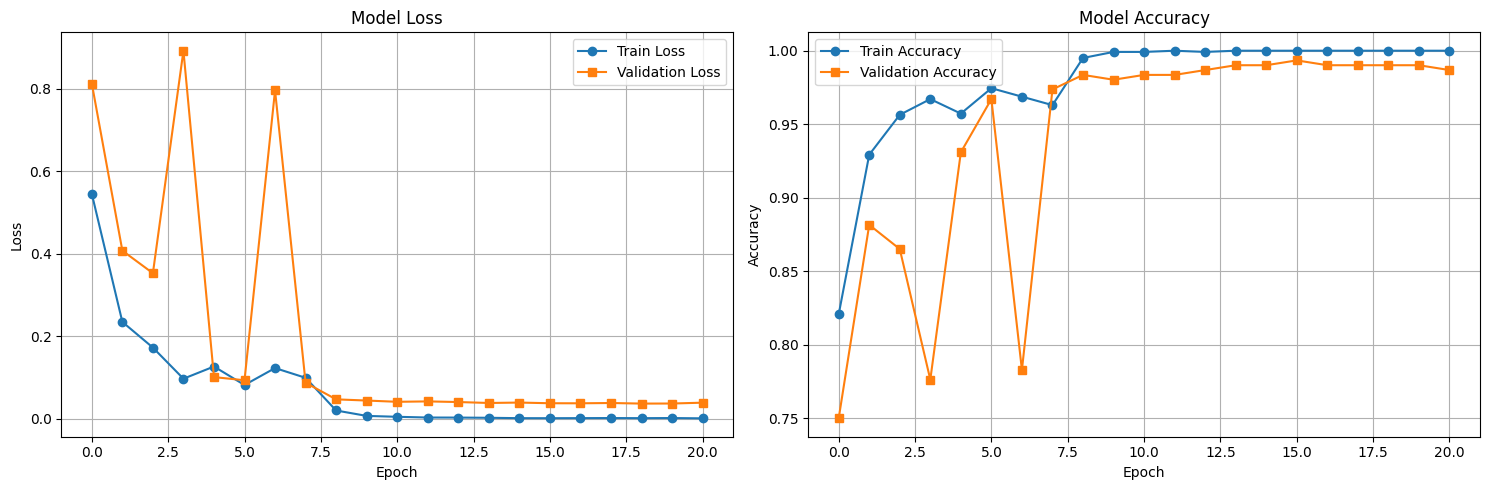

Evaluating on test set...


100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


Test Accuracy: 52.38%
Test Loss: 2.3906

Classification Report:
              precision    recall  f1-score   support

         HGC       0.65      0.69      0.67        74
         LGC       0.53      0.17      0.26        53
         NST       0.55      0.89      0.68        37
         NTL       0.18      0.24      0.20        25

    accuracy                           0.52       189
   macro avg       0.48      0.50      0.45       189
weighted avg       0.54      0.52      0.49       189


Confusion Matrix:
[[51  7  8  8]
 [26  9  2 16]
 [ 0  0 33  4]
 [ 1  1 17  6]]

ROC-AUC Scores:
Macro-average AUC: 0.6794
Micro-average AUC: 0.6993
HGC AUC: 0.7508
LGC AUC: 0.5166
NST AUC: 0.9159
NTL AUC: 0.5341


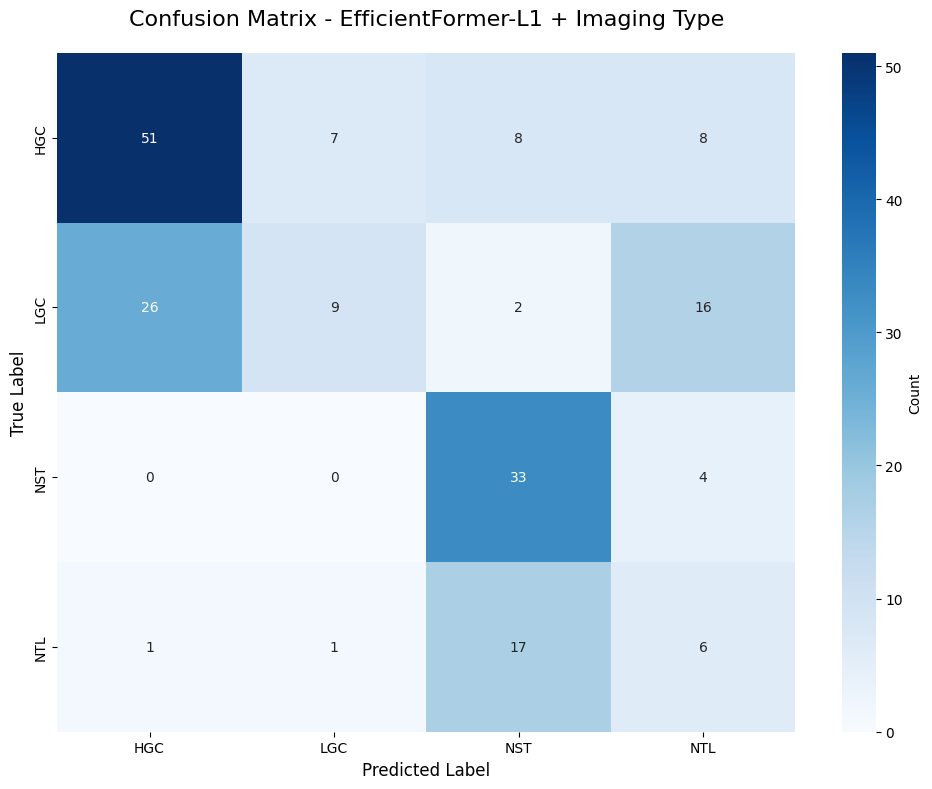

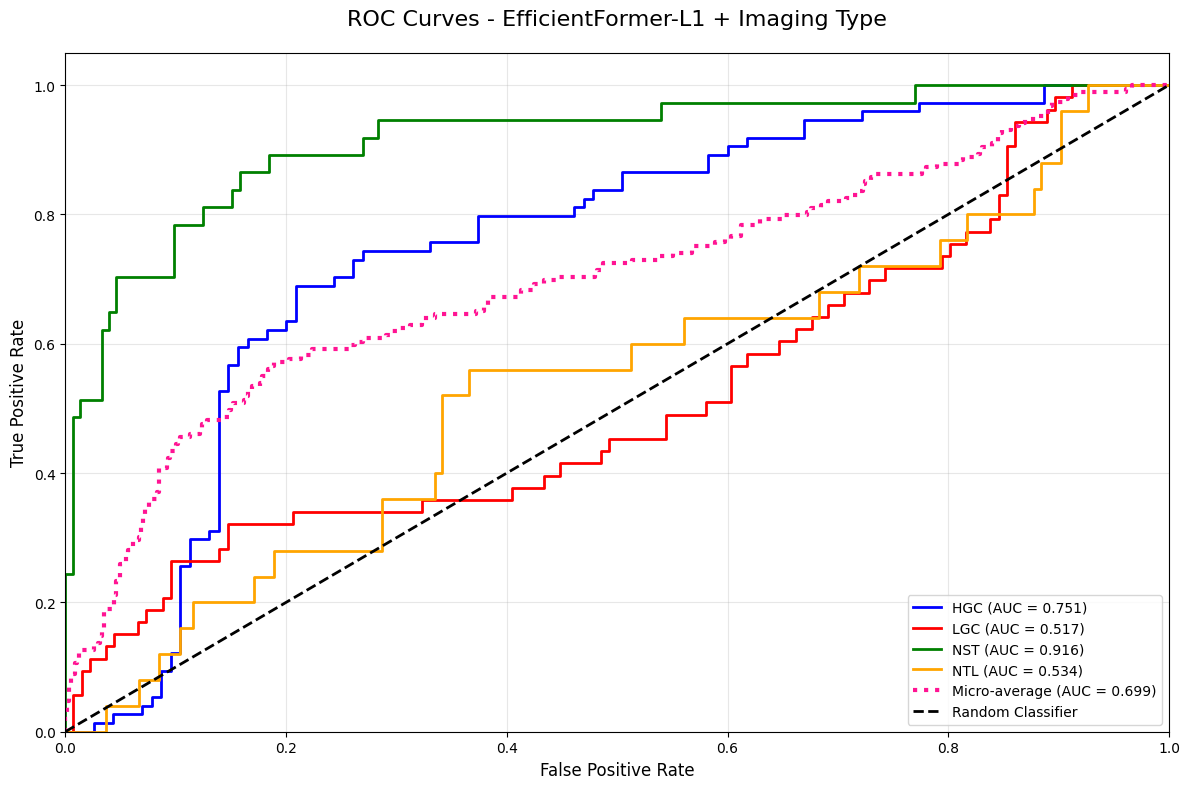


EfficientFormer L1 with Imaging Type training and evaluation complete!


In [16]:
print("=" * 80)
print("Training EfficientFormer L1 with Imaging Type")
print("=" * 80)

# Get number of imaging types
num_imaging_types = len(imaging_type_encoder.classes_)
print(f"Number of imaging types: {num_imaging_types}")
print(f"Imaging types: {imaging_type_encoder.classes_}")

# Create model
efficientformer_l1 = create_efficientformer_model(
    model_type='l1',
    num_classes=4,
    num_imaging_types=num_imaging_types,
    pretrained=True,
    embedding_dim=16
)

# Create trainer
trainer_efficientformer_l1 = ModelTrainer(efficientformer_l1, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_efficientformer_l1 = trainer_efficientformer_l1.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="EfficientFormer-L1_with_ImagingType")

# Plot training history
trainer_efficientformer_l1.plot_training_history(save_path='efficientformer_l1_with_imaging_training_history.png')

# Evaluate model
results_efficientformer_l1 = trainer_efficientformer_l1.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_efficientformer_l1['confusion_matrix'], class_names, 'EfficientFormer-L1 + Imaging Type',
                      save_path='efficientformer_l1_with_imaging_confusion_matrix.png')

# Plot ROC curves
roc_auc_efficientformer_l1 = plot_roc_curves(results_efficientformer_l1['labels'], results_efficientformer_l1['probabilities'], class_names, 'EfficientFormer-L1 + Imaging Type',
                                              save_path='efficientformer_l1_with_imaging_roc_curves.png')

# Store results
results_efficientformer_l1['model_name'] = 'EfficientFormer-L1'
results_efficientformer_l1['roc_auc'] = roc_auc_efficientformer_l1
all_results.append(results_efficientformer_l1)

print("\nEfficientFormer L1 with Imaging Type training and evaluation complete!")

## Train EfficientFormer L3

Training EfficientFormer L3 with Imaging Type


model.safetensors:   0%|          | 0.00/126M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:09<00:00,  3.93it/s, Loss=0.5582, Acc=0.8051]


Train Loss: 0.5582 Acc: 0.8051 Macro-F1: 0.7530


Val : 100%|██████████| 10/10 [00:01<00:00,  8.34it/s, Loss=1.1485, Acc=0.6053]


Val Loss: 1.1485 Acc: 0.6053 Macro-F1: 0.5376
✓ New best model saved with validation macro-F1: 0.5376

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:09<00:00,  3.94it/s, Loss=0.2095, Acc=0.9350]


Train Loss: 0.2095 Acc: 0.9350 Macro-F1: 0.9097


Val : 100%|██████████| 10/10 [00:01<00:00,  8.51it/s, Loss=0.6787, Acc=0.7237]


Val Loss: 0.6787 Acc: 0.7237 Macro-F1: 0.6781
✓ New best model saved with validation macro-F1: 0.6781

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:09<00:00,  3.92it/s, Loss=0.1706, Acc=0.9531]


Train Loss: 0.1706 Acc: 0.9531 Macro-F1: 0.9396


Val : 100%|██████████| 10/10 [00:01<00:00,  8.31it/s, Loss=0.2504, Acc=0.9079]


Val Loss: 0.2504 Acc: 0.9079 Macro-F1: 0.8751
✓ New best model saved with validation macro-F1: 0.8751

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:09<00:00,  3.93it/s, Loss=0.1914, Acc=0.9383]


Train Loss: 0.1914 Acc: 0.9383 Macro-F1: 0.9174


Val : 100%|██████████| 10/10 [00:01<00:00,  8.14it/s, Loss=0.4919, Acc=0.8553]


Val Loss: 0.4919 Acc: 0.8553 Macro-F1: 0.8501

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:09<00:00,  3.94it/s, Loss=0.2225, Acc=0.9383]


Train Loss: 0.2225 Acc: 0.9383 Macro-F1: 0.9194


Val : 100%|██████████| 10/10 [00:01<00:00,  8.45it/s, Loss=0.2304, Acc=0.9013]


Val Loss: 0.2304 Acc: 0.9013 Macro-F1: 0.8599

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:09<00:00,  3.94it/s, Loss=0.1248, Acc=0.9613]


Train Loss: 0.1248 Acc: 0.9613 Macro-F1: 0.9489


Val : 100%|██████████| 10/10 [00:01<00:00,  8.36it/s, Loss=0.0782, Acc=0.9671]


Val Loss: 0.0782 Acc: 0.9671 Macro-F1: 0.9646
✓ New best model saved with validation macro-F1: 0.9646

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:09<00:00,  3.94it/s, Loss=0.0450, Acc=0.9860]


Train Loss: 0.0450 Acc: 0.9860 Macro-F1: 0.9805


Val : 100%|██████████| 10/10 [00:01<00:00,  8.36it/s, Loss=0.0917, Acc=0.9704]


Val Loss: 0.0917 Acc: 0.9704 Macro-F1: 0.9720
✓ New best model saved with validation macro-F1: 0.9720

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:09<00:00,  3.92it/s, Loss=0.0345, Acc=0.9942]


Train Loss: 0.0345 Acc: 0.9942 Macro-F1: 0.9929


Val : 100%|██████████| 10/10 [00:01<00:00,  8.14it/s, Loss=0.0329, Acc=0.9836]


Val Loss: 0.0329 Acc: 0.9836 Macro-F1: 0.9871
✓ New best model saved with validation macro-F1: 0.9871

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:09<00:00,  3.92it/s, Loss=0.0070, Acc=0.9975]


Train Loss: 0.0070 Acc: 0.9975 Macro-F1: 0.9957


Val : 100%|██████████| 10/10 [00:01<00:00,  8.12it/s, Loss=0.0311, Acc=0.9934]


Val Loss: 0.0311 Acc: 0.9934 Macro-F1: 0.9948
✓ New best model saved with validation macro-F1: 0.9948

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:09<00:00,  3.94it/s, Loss=0.0031, Acc=0.9992]


Train Loss: 0.0031 Acc: 0.9992 Macro-F1: 0.9993


Val : 100%|██████████| 10/10 [00:01<00:00,  8.35it/s, Loss=0.0318, Acc=0.9901]


Val Loss: 0.0318 Acc: 0.9901 Macro-F1: 0.9876

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:09<00:00,  3.93it/s, Loss=0.0023, Acc=1.0000]


Train Loss: 0.0023 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  8.17it/s, Loss=0.0262, Acc=0.9934]


Val Loss: 0.0262 Acc: 0.9934 Macro-F1: 0.9948

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:09<00:00,  3.93it/s, Loss=0.0013, Acc=1.0000]


Train Loss: 0.0013 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  8.10it/s, Loss=0.0237, Acc=0.9934]


Val Loss: 0.0237 Acc: 0.9934 Macro-F1: 0.9948

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:09<00:00,  3.92it/s, Loss=0.0033, Acc=0.9992]


Train Loss: 0.0033 Acc: 0.9992 Macro-F1: 0.9982


Val : 100%|██████████| 10/10 [00:01<00:00,  8.06it/s, Loss=0.0260, Acc=0.9901]


Val Loss: 0.0260 Acc: 0.9901 Macro-F1: 0.9876

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:09<00:00,  3.91it/s, Loss=0.0008, Acc=1.0000]


Train Loss: 0.0008 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  8.10it/s, Loss=0.0274, Acc=0.9901]


Val Loss: 0.0274 Acc: 0.9901 Macro-F1: 0.9876
Early stopping triggered after 14 epochs
Training complete in 2m 35s
Best validation macro-F1: 0.9948


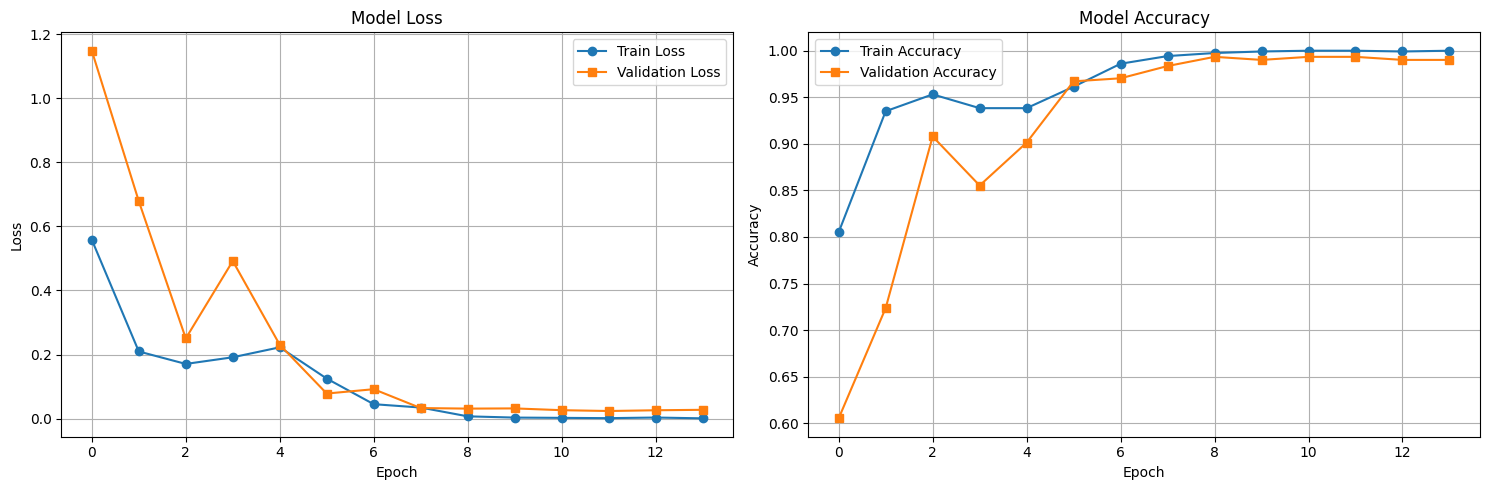

Evaluating on test set...


100%|██████████| 6/6 [00:00<00:00,  6.42it/s]


Test Accuracy: 59.26%
Test Loss: 1.7945

Classification Report:
              precision    recall  f1-score   support

         HGC       0.69      0.68      0.68        74
         LGC       0.54      0.47      0.51        53
         NST       0.76      0.35      0.48        37
         NTL       0.44      0.96      0.61        25

    accuracy                           0.59       189
   macro avg       0.61      0.61      0.57       189
weighted avg       0.63      0.59      0.58       189


Confusion Matrix:
[[50 21  2  1]
 [21 25  2  5]
 [ 0  0 13 24]
 [ 1  0  0 24]]

ROC-AUC Scores:
Macro-average AUC: 0.7905
Micro-average AUC: 0.7883
HGC AUC: 0.7405
LGC AUC: 0.6504
NST AUC: 0.8261
NTL AUC: 0.9449


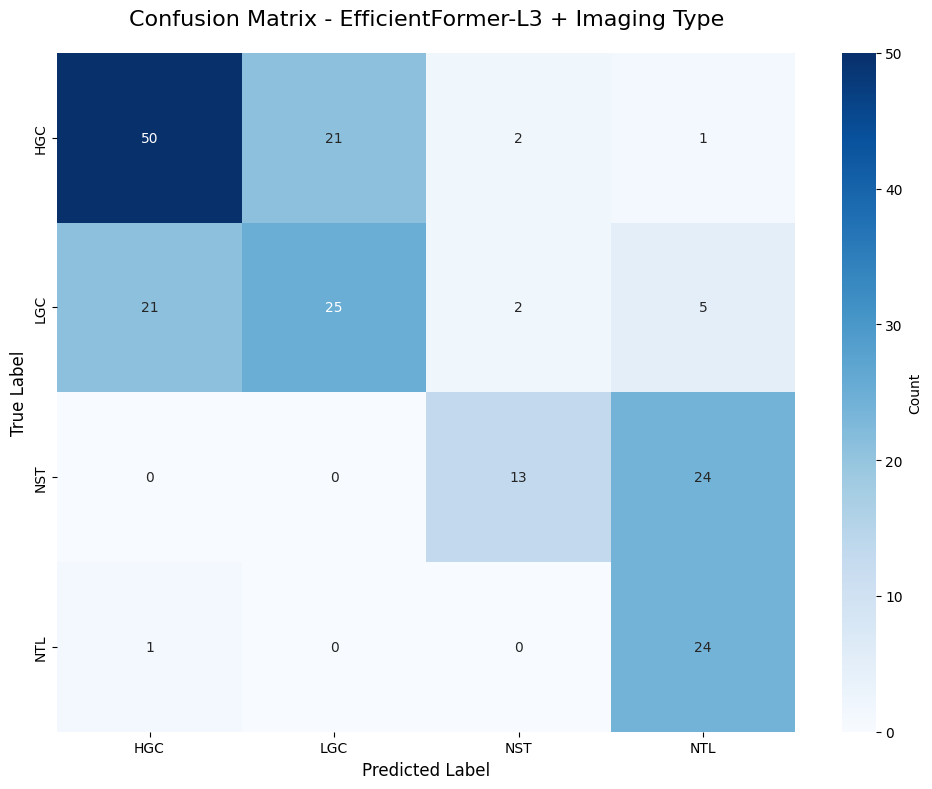

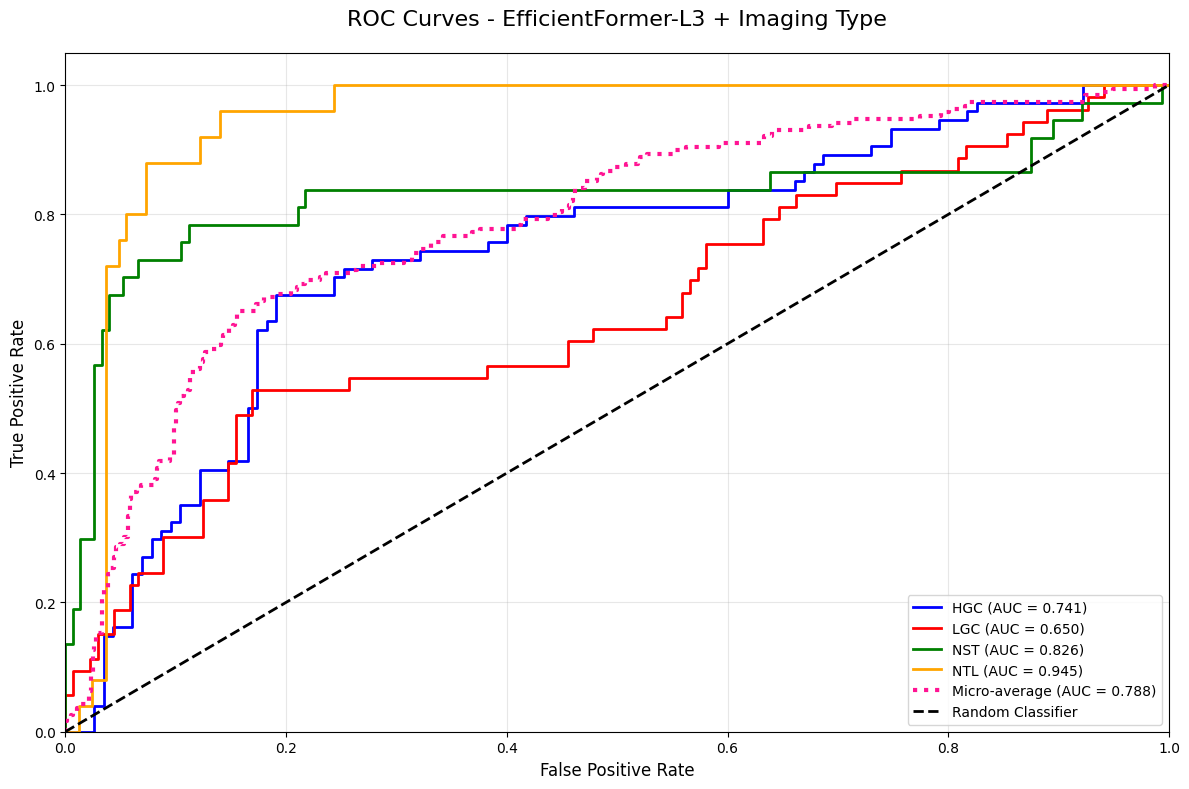


EfficientFormer L3 with Imaging Type training and evaluation complete!


In [17]:
print("=" * 80)
print("Training EfficientFormer L3 with Imaging Type")
print("=" * 80)

# Create model
efficientformer_l3 = create_efficientformer_model(
    model_type='l3',
    num_classes=4,
    num_imaging_types=num_imaging_types,
    pretrained=True,
    embedding_dim=16
)

# Create trainer
trainer_efficientformer_l3 = ModelTrainer(efficientformer_l3, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_efficientformer_l3 = trainer_efficientformer_l3.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="EfficientFormer-L3_with_ImagingType")

# Plot training history
trainer_efficientformer_l3.plot_training_history(save_path='efficientformer_l3_with_imaging_training_history.png')

# Evaluate model
results_efficientformer_l3 = trainer_efficientformer_l3.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_efficientformer_l3['confusion_matrix'], class_names, 'EfficientFormer-L3 + Imaging Type',
                      save_path='efficientformer_l3_with_imaging_confusion_matrix.png')

# Plot ROC curves
roc_auc_efficientformer_l3 = plot_roc_curves(results_efficientformer_l3['labels'], results_efficientformer_l3['probabilities'], class_names, 'EfficientFormer-L3 + Imaging Type',
                                              save_path='efficientformer_l3_with_imaging_roc_curves.png')

# Store results
results_efficientformer_l3['model_name'] = 'EfficientFormer-L3'
results_efficientformer_l3['roc_auc'] = roc_auc_efficientformer_l3
all_results.append(results_efficientformer_l3)

print("\nEfficientFormer L3 with Imaging Type training and evaluation complete!")

# Save All Metrics to CSV

In [18]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'EfficientFormer_with_ImagingType_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: EfficientFormer_with_ImagingType_metrics.csv

Metrics Summary:
                Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0  EfficientFormer-L1         52.380952      2.390640             0.477432          0.497723      0.452999                0.535477             0.523810         0.494955       0.653846    0.689189  0.671053         74.0       0.529412    0.169811  0.257143         53.0       0.550000    0.891892  0.680412         37.0       0.176471        0.24  0.203390         25.0   0.679364   0.699262  0.750764  0.516648 